In [14]:
import sys
import numpy as np
import pandas as pd
import torch
import torchvision
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
import numpy.random as random
from tqdm.notebook import tqdm
import os
import gc
from PIL import Image
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [2]:
!nvidia-smi

Wed May  1 20:34:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:B2:00.0 Off |                    0 |
| N/A   28C    P0              53W / 300W |   1249MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
class LayerNorm(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class GRN(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

In [4]:
img_config = {
    'batch_size': 16, # Increase this if your GPU can handle it
    'lr': 1e-3,
    'epochs': 30,
    # Include other parameters as needed.
}

class CustomImageDataset(torchvision.datasets.VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        # Assuming that the images are organized in subfolders representing classes.
        self.classes, self.class_to_idx = self._find_classes(root)
        self.samples = self.make_dataset(root, self.class_to_idx)
        self.targets = [s[1] for s in self.samples]

    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.
        """
        if not os.path.isdir(dir):
            raise FileNotFoundError(f"Couldn't find directory: {dir}")
        classes = sorted(entry.name for entry in os.scandir(dir) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        classes = classes[0:]
        return classes, class_to_idx

    def make_dataset(self, directory, class_to_idx):
        instances = []
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in fnames:
                    if fname.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff', 'tif')):
                        path = os.path.join(root, fname)
                        instances.append((path, class_index))
        return instances

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        
        sample = self.loader(path)
            

        if self.transform is not None:
            sample = self.transform(sample)
            # mask = np.ones_like(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        # if self.target_transform is None:
        #     target = np.eye(len(self.classes))[int(target)]
        return sample, target

    def __len__(self):
        return len(self.samples)


    def loader(self, path):
        try:
            # Open the image file, avoiding automatic resource management to control the closing process
            with open(path, 'rb') as f:
              image = Image.open(path)
              if image.mode in ['I', 'F', 'I;16', 'I;16L', 'I;16B', 'I;16N']:
                    image_array = np.array(image, dtype=np.int32)
                    max_val = image_array.max()
                    if max_val > 0:image = Image.fromarray((image_array / max_val * 255).astype(np.uint8))
              if image.mode != 'RGB': image = image.convert('RGB')

            return image
        except Exception:
            print(f"Failed to load image {path}. Skipping.")
            return None


class ClassificationVisualizeDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx])
        if image.mode in ['I', 'F', 'I;16', 'I;16L', 'I;16B', 'I;16N']:
            image_array = np.array(image, dtype=np.int32)
            max_val = image_array.max()
            if max_val > 0:image = Image.fromarray((image_array / max_val * 255).astype(np.uint8))
        if image.mode != 'RGB': image = image.convert('RGB')
        # mask = np.ones_like(self.transforms(image))
        return self.transforms(image)# , mask


# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]

mean=[0.4195, 0.3118, 0.1418]
std=[0.2289, 0.2239, 0.2249]

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(degrees=[-15, 15], scale=(1/1.2, 1.2)),  # Random stretching
    # torchvision.transforms.GaussianBlur(kernel_size=(7,7),sigma=(0.1,0.2)),
    torchvision.transforms.Resize((224, 224)), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean,std)
])
valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean,std)
])

TRAIN_DIR = '/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean/train'
VAL_DIR = "/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean/dev"
TEST_DIR = "/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean/test"

train_dataset   = CustomImageDataset(TRAIN_DIR, transform= train_transforms)
valid_dataset   = CustomImageDataset(VAL_DIR, transform= valid_transforms)
test_dataset    = ClassificationVisualizeDataset(TEST_DIR, transforms =valid_transforms)


train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = img_config['batch_size'],
    shuffle     = True,
    num_workers = 20,
    pin_memory = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = img_config['batch_size'],
    shuffle     = False,
    num_workers = 8,
    pin_memory = True
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = img_config['batch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", img_config['batch_size'])
print("Train batches        : ", train_loader.__len__())

Number of classes    :  3
No. of train images  :  19588
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  16
Train batches        :  1225


In [6]:
print("Number of classes    : ", len(valid_dataset.classes))
print("No. of valid images  : ", valid_dataset.__len__() )
print("Shape of image       : ", valid_dataset[0][0].shape)
print("Batch size           : ", img_config['batch_size'])
print("Valid batches        : ", valid_loader.__len__())

Number of classes    :  3
No. of valid images  :  1224
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  16
Valid batches        :  77


In [7]:
print("No. of test images  : ", test_dataset.__len__() )
print("Shape of image      : ", test_dataset[0].shape)
print("Batch size          : ", img_config['batch_size'])
print("Test batches        : ", test_loader.__len__())

No. of test images  :  3674
Shape of image      :  torch.Size([3, 224, 224])
Batch size          :  16
Test batches        :  230


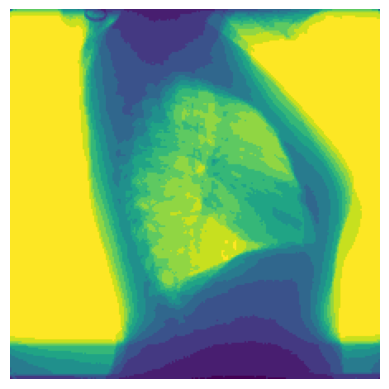

In [8]:
def load_and_preprocess_images(image_path, image_size=(224, 224)):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_size),
        torchvision.transforms.ToTensor()
    ])

    image = Image.open(image_path)
    if image.mode in ['P', 'I']: image = Image.fromarray((np.array(image) / 256).astype('uint8'))
    if image.mode != 'RGB': image = image.convert('RGB')
    image_tensor = transform(image)

    return image_tensor

images_tensor = load_and_preprocess_images('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean/train/0/16908_bimcv_neg.png')

def imshow(img_tensor):
    plt.imshow(img_tensor)
    plt.axis('off')
    plt.show()
imshow(images_tensor[0])

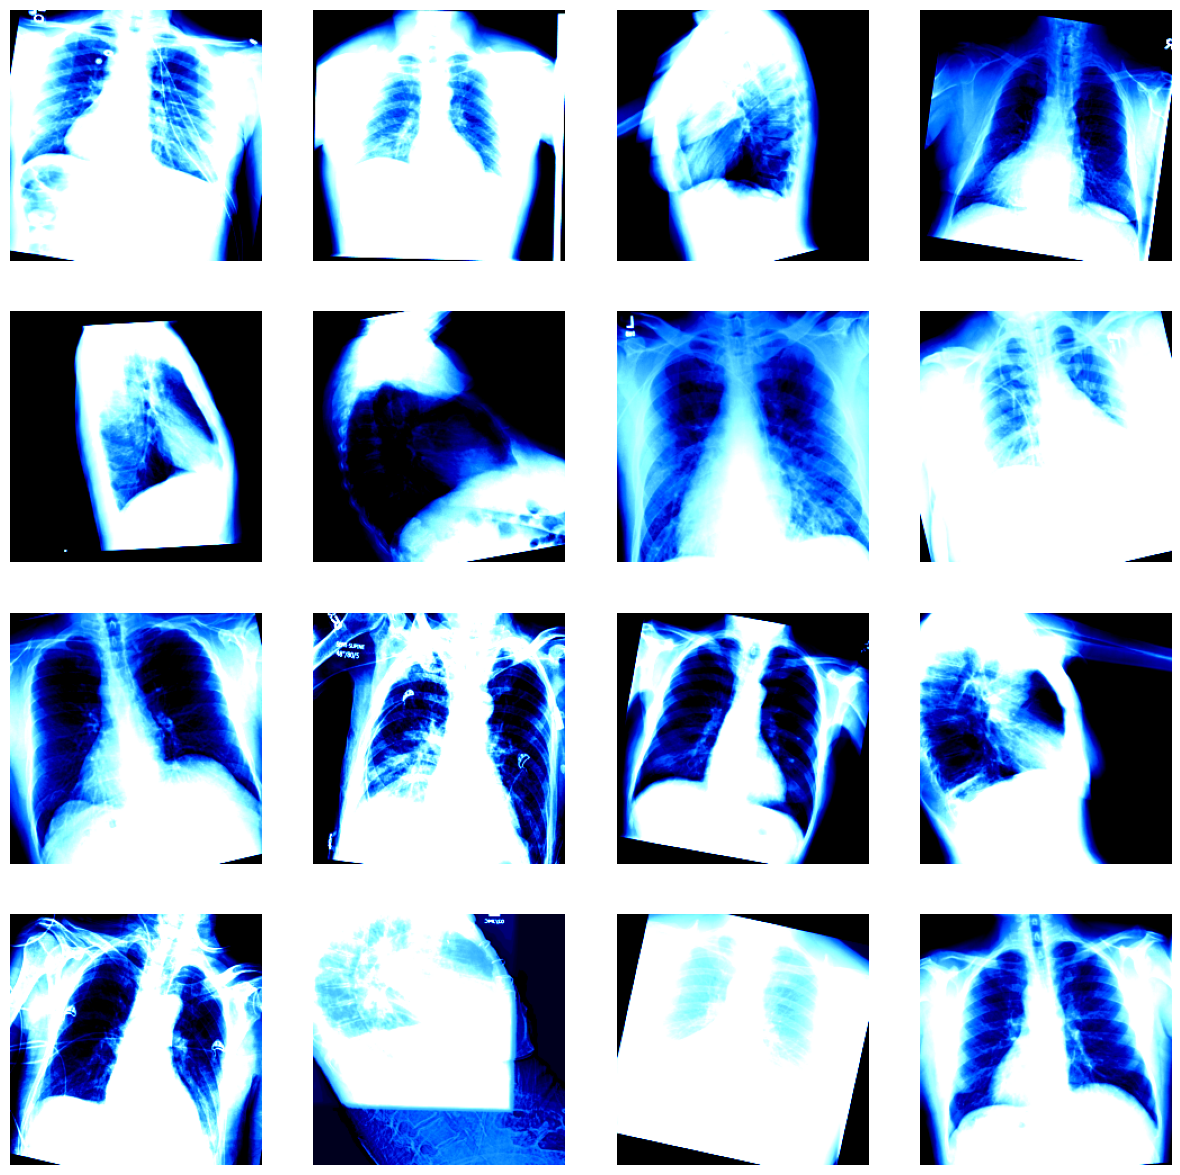

In [21]:
r, c    = [4, 4]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = train_dataset, # dont wanna see the images with transforms
    batch_size  = img_config['batch_size'],
    shuffle     = True,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].clamp(0, 1).numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=False)
# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} GPUs are available")
    model = nn.DataParallel(model)
model = model.to(DEVICE)
summary(model, (3, 224, 224))

Using cache found in /jet/home/mgao5/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


2 GPUs are available
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=img_config['lr'], weight_decay=1e-4)
# scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=1, verbose=True, threshold=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

scaler = torch.cuda.amp.GradScaler() # (Mixed precision training)


In [12]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0
    
    num_classes = 3
    TP = torch.zeros(num_classes, dtype=torch.long, device='cuda')
    FP = torch.zeros(num_classes, dtype=torch.long, device='cuda')
    FN = torch.zeros(num_classes, dtype=torch.long, device='cuda')
    precision = torch.zeros(num_classes, dtype=torch.float, device='cuda')

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): 
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())
        
        for k in range(num_classes):
            TP[k] += ((torch.argmax(outputs, axis=1) == k) & (labels == k)).sum()
            FP[k] += ((torch.argmax(outputs, axis=1) == k) & (labels != k)).sum()
            FN[k] += ((torch.argmax(outputs, axis=1) != k) & (labels == k)).sum()

        for k in range(num_classes):
            if TP[k] + FP[k] > 0:
                precision[k] = TP[k] / (TP[k] + FP[k])

        #add some details of monitor training
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (img_config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.06f}".format(float(optimizer.param_groups[0]['lr'])),
            precision_0 = "{:.04f}".format(precision[0].item()),
            precision_1 = "{:.04f}".format(precision[1].item()),
            precision_2 = "{:.04f}".format(precision[2].item())
        )

        scaler.scale(loss).backward() # replacement for loss.backward()
        scaler.step(optimizer) # replacement for optimizer.step()
        scaler.update()


        batch_bar.update() # Update tqdm bar

    batch_bar.close() 

    acc         = 100 * num_correct / (img_config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [15]:
def validate(model, dataloader, criterion):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    # Lists to collect true and predicted labels for the confusion matrix
    all_labels = []
    all_preds = []

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Update the number of correctly classified images
        preds = torch.argmax(outputs, axis=1)
        num_correct += int((preds == labels).sum())
        total_loss += float(loss.item())

        # Collect all true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (img_config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (img_config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non', 'Non-Covid-Pne','Covid-Pne'])
    
    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return acc, total_loss

In [16]:
gc.collect() 
torch.cuda.empty_cache()

In [ ]:
wandb.login(key="")

In [ ]:

run = wandb.init(
    name = "Res_Net_101_org_X-ray", #
    reinit = False, ### Allows reinitalizing runs
    #id = "",### Insert specific run id here if you want to resume a previous run
    resume = "allow", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "X-ray", ### Project should be created in your wandb account
    config = img_config ### Wandb Config for your run
)

In [17]:
checkpoint = torch.load('/jet/home/mgao5/Conv_Next_V2/org_101_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
val_acc = checkpoint['val_acc']

In [19]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

In [18]:
scheduler.get_last_lr()

[5.902958103587065e-06]

In [18]:
# scheduler.step()
# scheduler.get_last_lr()

In [ ]:
best_valacc = 0

for epoch in range(img_config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1,
        img_config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    scheduler.step()


    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, '/jet/home/mgao5/Conv_Next_V2/org_101_checkpoint.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
# run.finish()

Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 1/30: 
Train Acc 61.6378%	 Train Loss 0.8011	 Learning Rate 0.000210


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 62.2565%	 Val Loss 0.7564
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 2/30: 
Train Acc 62.4082%	 Train Loss 0.7882	 Learning Rate 0.000168


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 60.3896%	 Val Loss 0.8134


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 3/30: 
Train Acc 63.3316%	 Train Loss 0.7718	 Learning Rate 0.000134


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 65.0974%	 Val Loss 0.7332
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 4/30: 
Train Acc 63.6786%	 Train Loss 0.7667	 Learning Rate 0.000107


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 65.0974%	 Val Loss 0.7367
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 5/30: 
Train Acc 64.6378%	 Train Loss 0.7519	 Learning Rate 0.000086


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 66.2338%	 Val Loss 0.7123
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 6/30: 
Train Acc 65.3878%	 Train Loss 0.7390	 Learning Rate 0.000069


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 65.3409%	 Val Loss 0.7214


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 7/30: 
Train Acc 65.2041%	 Train Loss 0.7349	 Learning Rate 0.000055


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 65.4221%	 Val Loss 0.7149


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 8/30: 
Train Acc 66.0204%	 Train Loss 0.7261	 Learning Rate 0.000044


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 65.5844%	 Val Loss 0.7170


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 9/30: 
Train Acc 66.0459%	 Train Loss 0.7203	 Learning Rate 0.000035


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 66.9643%	 Val Loss 0.6946
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 10/30: 
Train Acc 66.7500%	 Train Loss 0.7112	 Learning Rate 0.000028


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 67.1266%	 Val Loss 0.7228
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 11/30: 
Train Acc 67.2959%	 Train Loss 0.7050	 Learning Rate 0.000023


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 68.5877%	 Val Loss 0.6807
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 12/30: 
Train Acc 67.3827%	 Train Loss 0.7008	 Learning Rate 0.000018


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 68.5877%	 Val Loss 0.6830
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 13/30: 
Train Acc 67.3929%	 Train Loss 0.6986	 Learning Rate 0.000014


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 68.3442%	 Val Loss 0.6835


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 14/30: 
Train Acc 67.6735%	 Train Loss 0.6942	 Learning Rate 0.000012


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 68.1818%	 Val Loss 0.6795


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 15/30: 
Train Acc 68.0306%	 Train Loss 0.6874	 Learning Rate 0.000009


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 68.6688%	 Val Loss 0.6786
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]


Epoch 16/30: 
Train Acc 67.5153%	 Train Loss 0.6913	 Learning Rate 0.000007


Val:   0%|          | 0/77 [00:00<?, ?it/s]

Val Acc 68.9935%	 Val Loss 0.6720
Saving model


Train:   0%|          | 0/1225 [00:00<?, ?it/s]

In [ ]:
best_valacc = 0

for epoch in range(img_config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1,
        img_config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    scheduler.step()


    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, '/jet/home/mgao5/Conv_Next_V2/checkpoint.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
# run.finish()

Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 1/20: 
Train Acc 71.2862%	 Train Loss 0.6267	 Learning Rate 0.000023


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 68.8596%	 Val Loss 0.6626
Saving model


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 2/20: 
Train Acc 71.7600%	 Train Loss 0.6246	 Learning Rate 0.000018


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 70.0658%	 Val Loss 0.6337
Saving model


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 3/20: 
Train Acc 71.3907%	 Train Loss 0.6232	 Learning Rate 0.000014


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 64.3640%	 Val Loss 0.7831


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 4/20: 
Train Acc 71.3838%	 Train Loss 0.6227	 Learning Rate 0.000012


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 67.3246%	 Val Loss 0.6704


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 5/20: 
Train Acc 71.4813%	 Train Loss 0.6211	 Learning Rate 0.000009


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 69.2982%	 Val Loss 0.6339


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 6/20: 
Train Acc 71.2514%	 Train Loss 0.6255	 Learning Rate 0.000007


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 69.4079%	 Val Loss 0.6307


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 7/20: 
Train Acc 71.1329%	 Train Loss 0.6240	 Learning Rate 0.000006


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 70.3947%	 Val Loss 0.6232
Saving model


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 8/20: 
Train Acc 71.3141%	 Train Loss 0.6223	 Learning Rate 0.000005


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 69.2982%	 Val Loss 0.6358


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 9/20: 
Train Acc 71.7043%	 Train Loss 0.6224	 Learning Rate 0.000004


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 68.9693%	 Val Loss 0.6397


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 10/20: 
Train Acc 71.7391%	 Train Loss 0.6215	 Learning Rate 0.000003


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 66.7763%	 Val Loss 0.7001


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 11/20: 
Train Acc 71.4395%	 Train Loss 0.6241	 Learning Rate 0.000002


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 64.5833%	 Val Loss 0.7768


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 12/20: 
Train Acc 71.7182%	 Train Loss 0.6190	 Learning Rate 0.000002


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 68.5307%	 Val Loss 0.6468


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 13/20: 
Train Acc 71.4256%	 Train Loss 0.6202	 Learning Rate 0.000002


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 68.4211%	 Val Loss 0.6651


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 14/20: 
Train Acc 71.5580%	 Train Loss 0.6207	 Learning Rate 0.000001


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 68.9693%	 Val Loss 0.6377


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 15/20: 
Train Acc 71.5371%	 Train Loss 0.6215	 Learning Rate 0.000001


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 70.1754%	 Val Loss 0.6244


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 16/20: 
Train Acc 71.7391%	 Train Loss 0.6208	 Learning Rate 0.000001


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 69.9561%	 Val Loss 0.6443


Train:   0%|          | 0/897 [00:00<?, ?it/s]


Epoch 17/20: 
Train Acc 71.4395%	 Train Loss 0.6243	 Learning Rate 0.000001


Val:   0%|          | 0/57 [00:00<?, ?it/s]

Val Acc 66.4474%	 Val Loss 0.7109


Train:   0%|          | 0/897 [00:00<?, ?it/s]

Val:   0%|          | 0/77 [00:00<?, ?it/s]

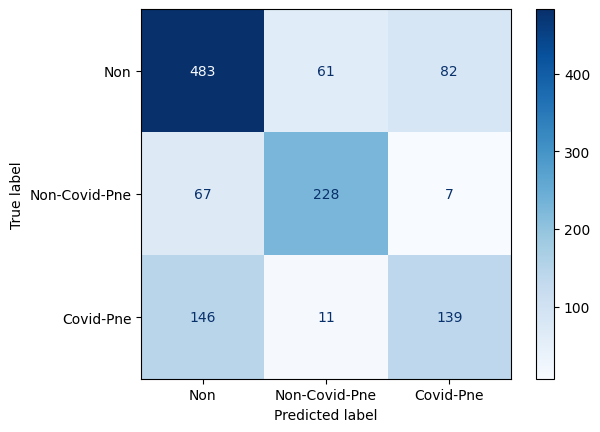

(68.99350649350649, 0.6720477528386302)

In [19]:
validate(model, valid_loader, criterion)

In [13]:
os.remove('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/16874_bimcv_neg.png')

In [15]:
os.remove('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/729_padchest.png')

In [10]:
os.path.exists('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/16874_bimcv_neg.png')

False

In [16]:
os.path.exists('/ocean/projects/cis230079p/shared/CapStone-VeyTel-2024/datasets/data-clean-v2/train/0/729_padchest.png')

False